In [345]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE

In [346]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354   

In [347]:
df = df.dropna(subset=['bmi'])
print(df.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


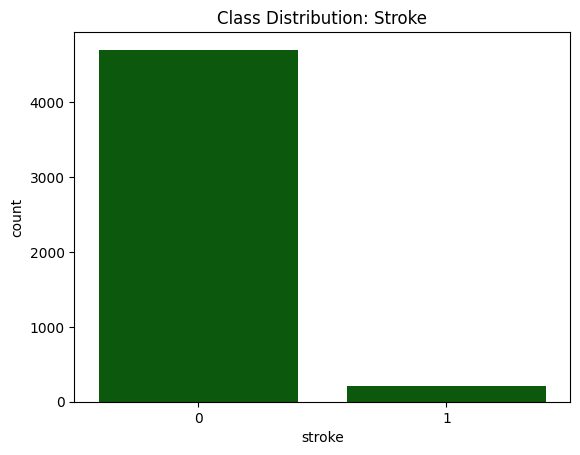

In [348]:
sns.countplot(x='stroke', data=df, color='darkgreen')
plt.title('Class Distribution: Stroke')
plt.show()

In [349]:
label_encoders = {}
for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    if column in df.columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

In [350]:
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

X = pd.get_dummies(X, drop_first=True)

In [351]:
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0, stratify=y_resampled)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [352]:
rf_model = RandomForestClassifier(random_state=0)
lr_model = LogisticRegression()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

accuracies = []
roc_auc_scores = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train.to_numpy()[train_idx], y_train.to_numpy()[val_idx]
    rf_model.fit(X_fold_train, y_fold_train)
    fold_predictions = rf_model.predict(X_fold_val)
    accuracies.append(accuracy_score(y_fold_val, fold_predictions))
    roc_auc_scores.append(roc_auc_score(y_fold_val, rf_model.predict_proba(X_fold_val)[:, 1]))

rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

LogisticRegression()

In [353]:
rf_predictions = rf_model.predict(X_test)
lr_predictions = lr_model.predict(X_test)

mse = mean_squared_error(y_test, lr_predictions)
r2 = r2_score(y_test, lr_predictions)

In [354]:
print("Cross-Validation Accuracy:", np.mean(accuracies))
print("Cross-Validation ROC AUC:", np.mean(roc_auc_scores))

print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("ROC AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))

Cross-Validation Accuracy: 0.942686170212766
Cross-Validation ROC AUC: 0.9881295269352648
Accuracy: 0.9462765957446808
ROC AUC: 0.9906875282933454
Confusion Matrix:
 [[859  81]
 [ 20 920]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       940
           1       0.92      0.98      0.95       940

    accuracy                           0.95      1880
   macro avg       0.95      0.95      0.95      1880
weighted avg       0.95      0.95      0.95      1880



In [355]:
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print("ROC AUC:", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_predictions))
print("Classification Report:\n", classification_report(y_test, lr_predictions))

Accuracy: 0.8079787234042554
ROC AUC: 0.8918571751923948
Confusion Matrix:
 [[739 201]
 [160 780]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80       940
           1       0.80      0.83      0.81       940

    accuracy                           0.81      1880
   macro avg       0.81      0.81      0.81      1880
weighted avg       0.81      0.81      0.81      1880



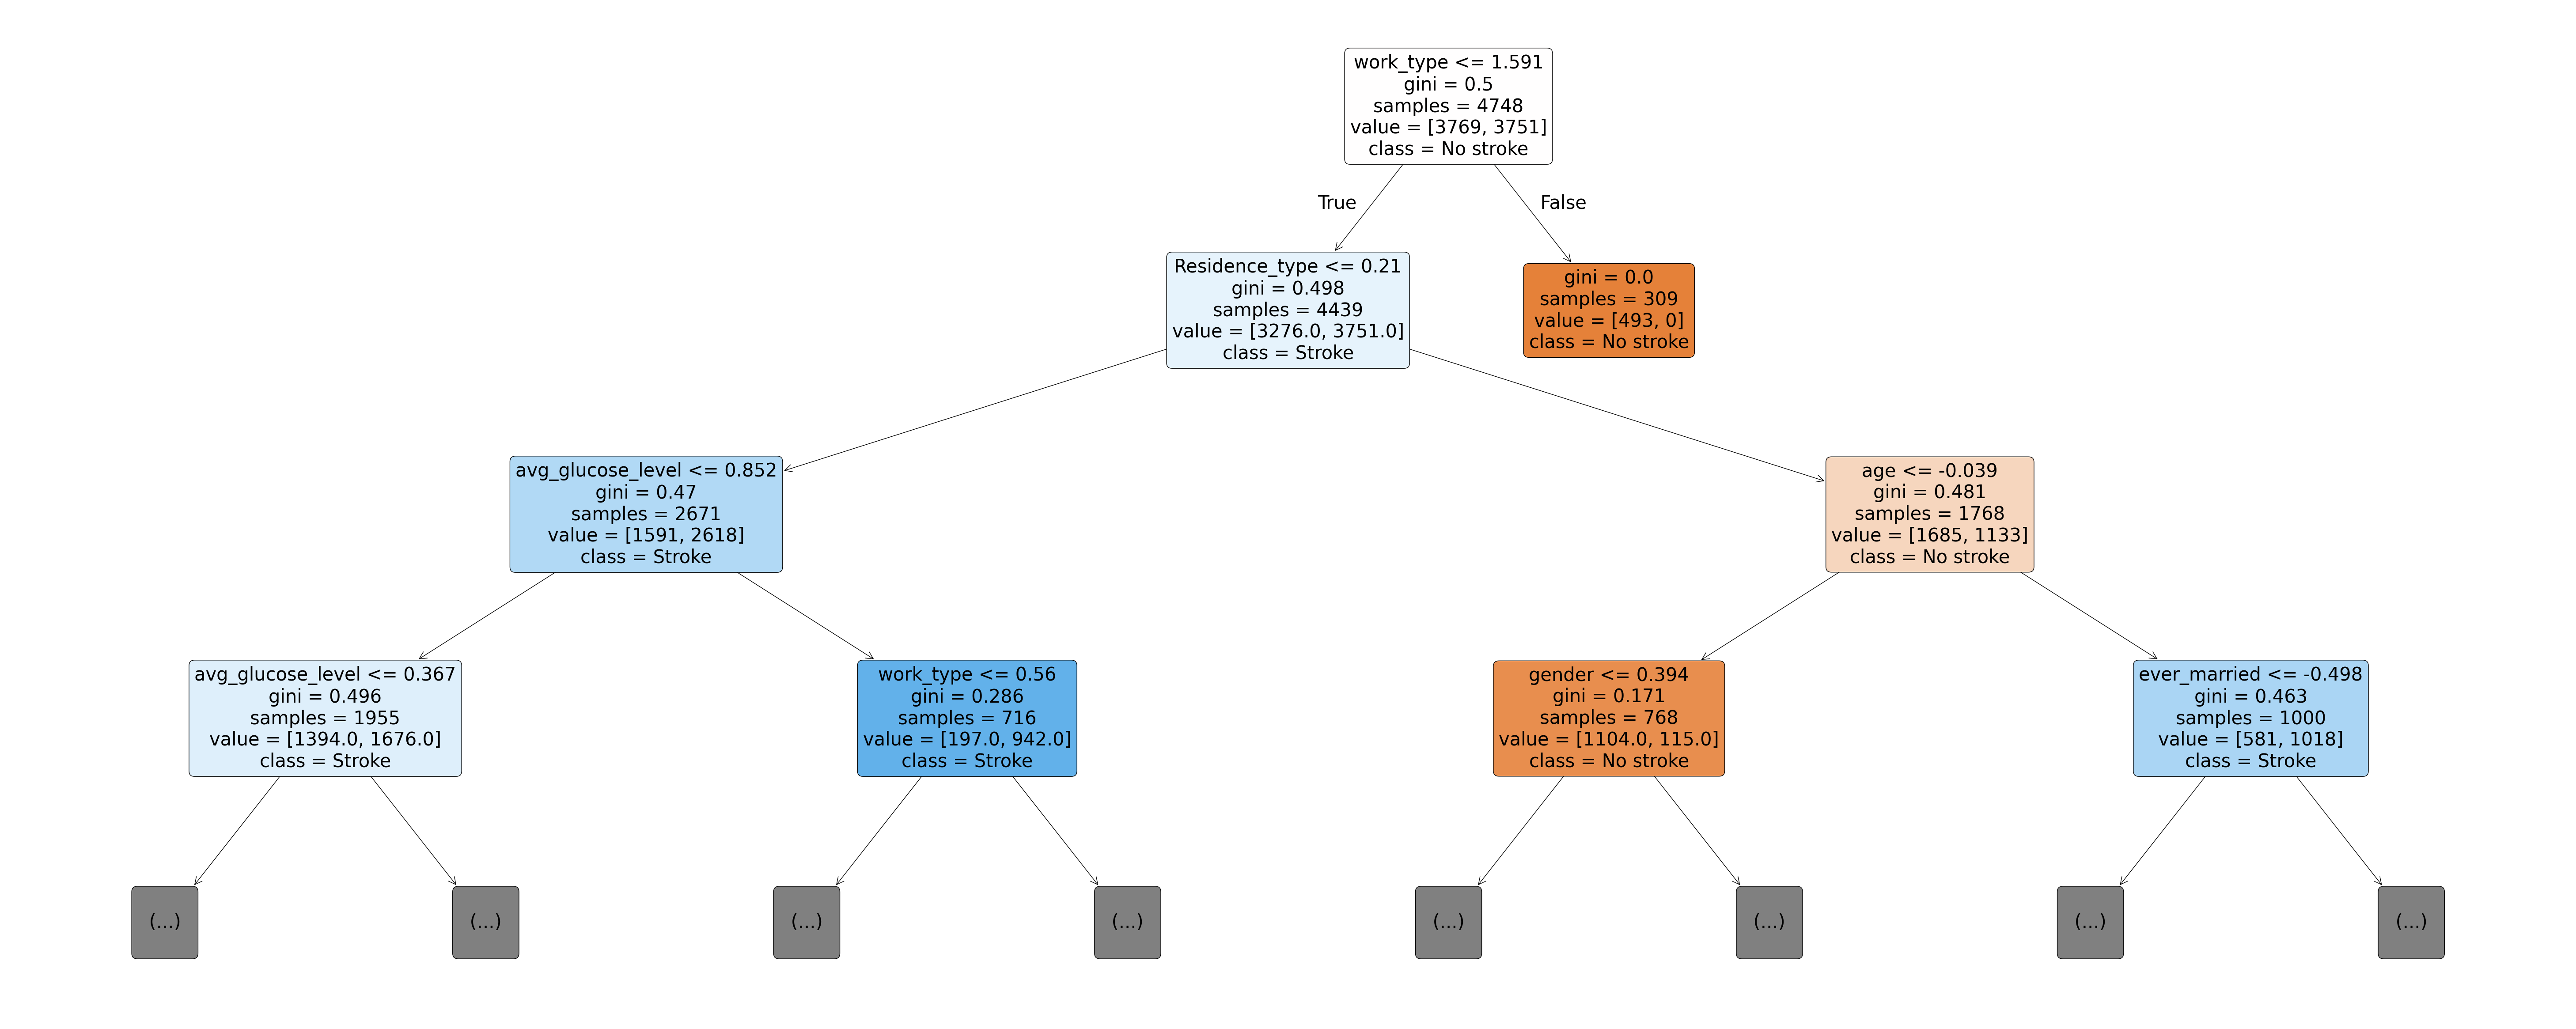

In [356]:
final_tree = rf_model.estimators_[-1]
plt.figure(figsize=(75, 30))
plot_tree(final_tree, feature_names=X.columns, class_names=['No stroke', 'Stroke'], filled=True, rounded=True, max_depth=3, fontsize=30)
plt.show()

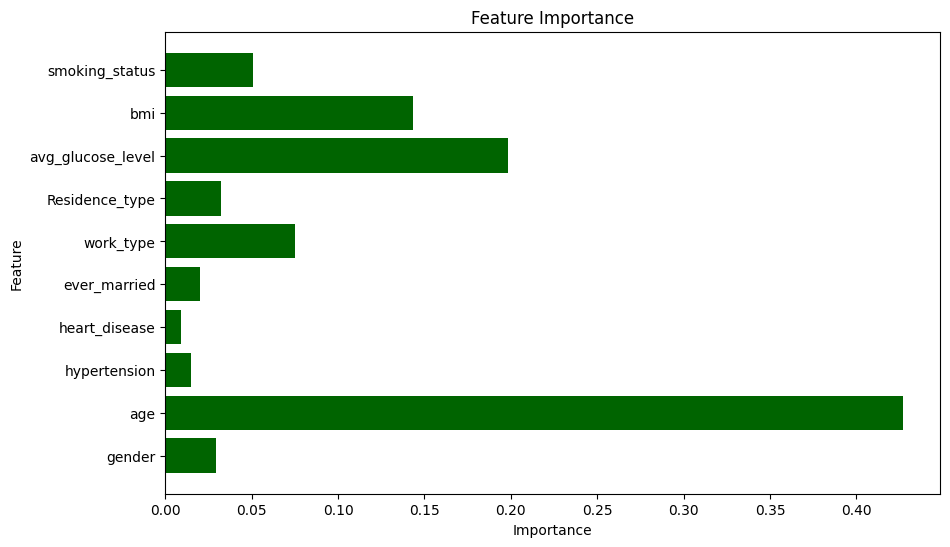

In [357]:
importances = rf_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='darkgreen')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()